#Exercise 1

Using the provided data "gme.csv", forecast the evolution of Gamestop daily returns and volume respectively for 1 and 3 years, notice how the confidence intervals change: what problems may be there? Can you improve the overall performance?

Hint: At the beginning of January 2021, Gamestop was involved in a short squeeze that led to an increased volatility during the two following months.

#Exercise 2

Using the provided data "jpy_usd.csv", forecast the USD/JPY weekly closing exchange rate for the next 2 years: can you spot the month characterized by the strongest seasonality in this dataset?

Hint: The american currency tends to depreciate against the japanese one during summer.

#Solution exercise 1

In [ ]:
# install library
!pip install prophet

In [1]:
# import necessary libraries
from prophet import Prophet

import numpy as np
import pandas as pd

In [2]:
# link drive to colab
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In the first step, we import the necessary data and prepare it for being fed to Prophet, by applying some filters, common for both parts of the task and for this reason directly carried out on the original dataframe.

In [3]:
# read dataset
gme = pd.read_csv("/content/gdrive/My Drive/projects/dafa/gme.csv")
gme

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,8.515000,8.540000,8.3125,8.450000,6.288958,6450800
1,2015-01-05,8.380000,8.720000,8.3325,8.680000,6.460136,19739600
2,2015-01-06,8.792500,9.007500,8.3800,8.422500,6.268491,19540400
3,2015-01-07,8.572500,8.670000,8.2450,8.325000,6.195926,10233200
4,2015-01-08,8.400000,8.542500,8.3300,8.422500,6.268491,18189600
...,...,...,...,...,...,...,...
2009,2022-12-23,20.000000,20.629999,19.6500,20.080000,20.080000,3174800
2010,2022-12-27,19.910000,19.990000,18.0000,18.200001,18.200001,4233000
2011,2022-12-28,18.290001,18.700001,16.9800,17.920000,17.920000,5672000
2012,2022-12-29,18.120001,18.570000,17.7500,18.330000,18.330000,3442800


In [4]:
# drop unnecessary columns
gme = gme.drop(columns = ["Open", "High", "Low", "Close"])

# change date column type to datetime, as required by Prophet and display dataset
gme["Date"] = pd.to_datetime(gme["Date"])
gme

,Date,Adj Close,Volume
0,2015-01-02,6.288958,6450800
1,2015-01-05,6.460136,19739600
2,2015-01-06,6.268491,19540400
3,2015-01-07,6.195926,10233200
4,2015-01-08,6.268491,18189600
...,...,...,...
2009,2022-12-23,20.080000,3174800
2010,2022-12-27,18.200001,4233000
2011,2022-12-28,17.920000,5672000
2012,2022-12-29,18.330000,3442800


We now create a copy of the filtered dataframe for further manipulation, and make it ready to be used by Prophet; note the transformation from price to continuously compounded returns, which leads to a missing value in the series, not impacting the model performance.

In [5]:
# create copy of dataset for further manipulation
gme_close = gme.copy()

# drop unnecessary column
gme_close = gme_close.drop(columns = ["Volume"])

# rename remaining columns to fit Prophet requirements
gme_close = gme_close.rename(columns = {"Date": "ds", "Adj Close": "y"})

# calculate continuous returns
gme_close["y"] = np.log(gme_close["y"] / gme_close["y"].shift())

# reverse the entry order so that most recent observations are on top and display the new dataframe
gme_close = gme_close.iloc[::-1].reset_index(drop = True)
gme_close

,ds,y
0,2022-12-30,0.007067
1,2022-12-29,0.022622
2,2022-12-28,-0.015504
3,2022-12-27,-0.098303
4,2022-12-23,0.013537
...,...,...
2009,2015-01-08,0.011644
2010,2015-01-07,-0.011644
2011,2015-01-06,-0.030115
2012,2015-01-05,0.026855


At this stage, we initialize the Prophet class to fit the processed data, to finally carry out the forecast for the predetermined time window, and showcase the results graphically; the outlier data points are well visible, and this information will be used in the next step.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/yo_49fv7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/zaa6m_b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66743', 'data', 'file=/tmp/tmp6czgpebd/yo_49fv7.json', 'init=/tmp/tmp6czgpebd/zaa6m_b8.json', 'output', 'file=/tmp/tmp6czgpebd/prophet_modelv7am6a5c/prophet_model-20230202060724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:07:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


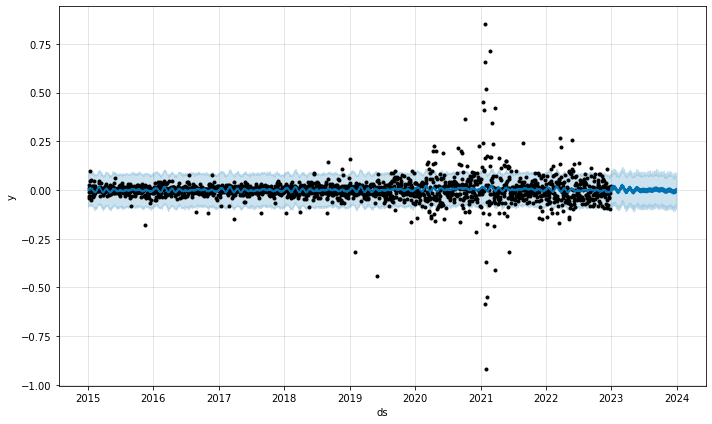

In [6]:
# initiate Prophet class
gme_close_model = Prophet()

# fit model with available data
gme_close_model.fit(gme_close)

# create dataframe for 1 year prediction
future_close = gme_close_model.make_future_dataframe(periods = 365)

# carry out the forecast
forecast_close = gme_close_model.predict(future_close)

# showcase forecast results
fig_close = gme_close_model.plot(forecast_close)

We can now iterate the same steps with the goal of forecasting volume, as shown below; note the logarithmic transformation of the volume variable, which better highlights the confidence interval dynamics charted in the following step.

In [7]:
# create copy of dataset for further manipulation
gme_volume = gme.copy()

# drop unnecessary column
gme_volume = gme_volume.drop(columns = ["Adj Close"])

# rename remaining columns to fit Prophet requirements
gme_volume = gme_volume.rename(columns = {"Date": "ds", "Volume": "y"})

# calculate natural logarithm of the volume
gme_volume["y"] = np.log(gme_volume["y"])

# reverse the entry order so that most recent observations are on top and display the new dataframe
gme_volume = gme_volume.iloc[::-1].reset_index(drop = True)
gme_volume

,ds,y
0,2022-12-30,14.795001
1,2022-12-29,15.051796
2,2022-12-28,15.551052
3,2022-12-27,15.258422
4,2022-12-23,14.970755
...,...,...
2009,2015-01-08,16.716361
2010,2015-01-07,16.141148
2011,2015-01-06,16.787995
2012,2015-01-05,16.798137


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/71knue5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/a7t0llwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5321', 'data', 'file=/tmp/tmp6czgpebd/71knue5r.json', 'init=/tmp/tmp6czgpebd/a7t0llwb.json', 'output', 'file=/tmp/tmp6czgpebd/prophet_model2c4z0g72/prophet_model-20230202060737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


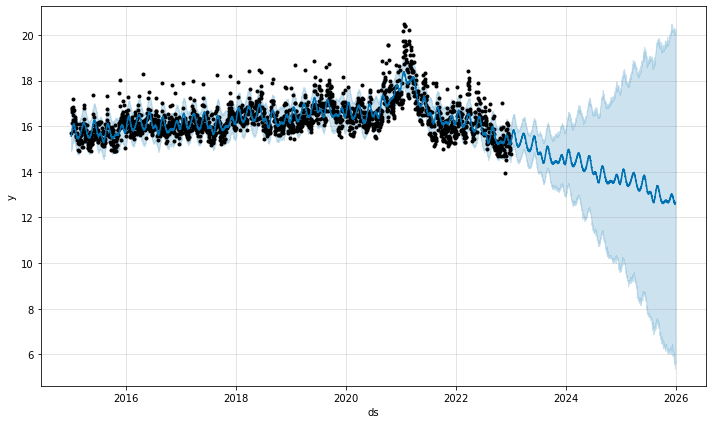

In [8]:
# initiate Prophet class
gme_volume_model = Prophet()

# fit model with available data
gme_volume_model.fit(gme_volume)

# create dataframe for 3 years prediction
future_volume = gme_volume_model.make_future_dataframe(periods = 1095)

# carry out the forecast
forecast_volume = gme_volume_model.predict(future_volume)

# showcase forecast results
fig_volume = gme_volume_model.plot(forecast_volume)

To try and improve the model's performance, we exclude some outliers from the filtered dataframe and repeat the forecast.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/wr1v3310.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/8gfwsdxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6012', 'data', 'file=/tmp/tmp6czgpebd/wr1v3310.json', 'init=/tmp/tmp6czgpebd/8gfwsdxm.json', 'output', 'file=/tmp/tmp6czgpebd/prophet_modelihhq1occ/prophet_model-20230202060804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


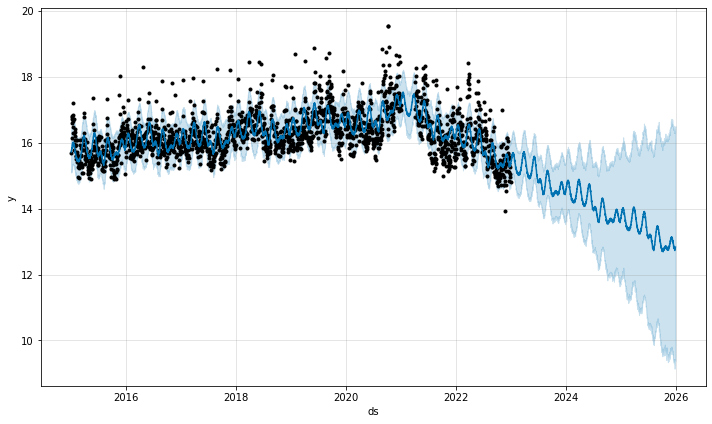

In [9]:
# exclude most volatile months from the dataset
gme_volume.loc[(gme_volume["ds"] > "2021-01-01") & (gme_volume["ds"] < "2021-04-01"), "y"] = None

# fit the model to data excluding outliers
gme_volume_model = Prophet().fit(gme_volume)

# show the fixed forecast
fig_volume = gme_volume_model.plot(gme_volume_model.predict(future_volume))

It's possible to observe how the forecasting dynamics hasn't changed, leading to a value around 13 in 2026, whereas the confidence intervals have sensibly reduced, from 20 - 5 to 16 - 9.

#Solution exercise 2

Following the same reasoning characterizing the previous task, we import and clean the raw data.

In [10]:
# read dataset
jpy = pd.read_csv("/content/gdrive/My Drive/projects/dafa/jpy_usd.csv")
jpy

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-01,102.180000,105.879997,101.309998,105.330002,105.330002,0.0
1,2000-01-08,105.349998,107.309998,104.279999,105.879997,105.879997,0.0
2,2000-01-15,105.870003,107.400002,104.250000,104.720001,104.720001,0.0
3,2000-01-22,104.720001,107.250000,104.099998,107.059998,107.059998,0.0
4,2000-01-29,107.059998,109.040001,106.540001,107.180000,107.180000,0.0
...,...,...,...,...,...,...,...
1196,2022-12-03,134.309998,137.837997,134.134003,136.613998,136.613998,0.0
1197,2022-12-10,136.559998,137.942001,134.681000,137.751007,137.751007,0.0
1198,2022-12-17,136.699997,137.451996,131.016998,132.356995,132.356995,0.0
1199,2022-12-24,132.759995,134.395004,131.541000,132.916000,132.916000,0.0


This time we don't transform the data in order to get returns, as previously done, to retain the seasonality component to be showcased in the final step, which would otherwise not be evident.

In [11]:
# drop unnecessary columns
jpy = jpy.drop(columns = ["Open", "High", "Low", "Adj Close", "Volume"])

# change date column type to datetime, as required by Prophet
jpy["Date"] = pd.to_datetime(jpy["Date"])

# rename remaining columns to fit Prophet requirements and display dataset
jpy = jpy.rename(columns = {"Date": "ds", "Close": "y"})
jpy

,ds,y
0,2000-01-01,105.330002
1,2000-01-08,105.879997
2,2000-01-15,104.720001
3,2000-01-22,107.059998
4,2000-01-29,107.180000
...,...,...
1196,2022-12-03,136.613998
1197,2022-12-10,137.751007
1198,2022-12-17,132.356995
1199,2022-12-24,132.916000


We fit the model to the data, exactly as above, to then display the forecast.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/ty2rq5cy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6czgpebd/9zpg_gd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95134', 'data', 'file=/tmp/tmp6czgpebd/ty2rq5cy.json', 'init=/tmp/tmp6czgpebd/9zpg_gd_.json', 'output', 'file=/tmp/tmp6czgpebd/prophet_modelxg31l8jq/prophet_model-20230202060823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


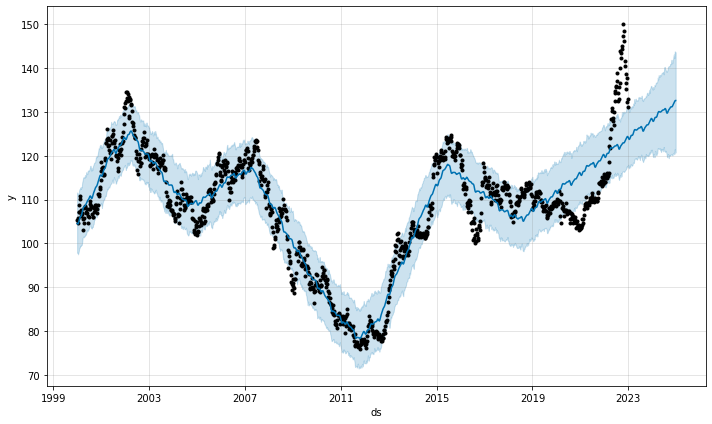

In [12]:
# initiate Prophet class
jpy_model = Prophet()

# fit model with available data
jpy_model.fit(jpy)

# create dataframe for 2 years weekly prediction
future = jpy_model.make_future_dataframe(periods = 104, freq = "W")

# carry out the forecast
forecast = jpy_model.predict(future)

# showcase forecast results
fig_jpy = jpy_model.plot(forecast)

To complete the second task, we proceed to show the trend and, in particular, the seasonality components; a strong negative component is to be found in August.

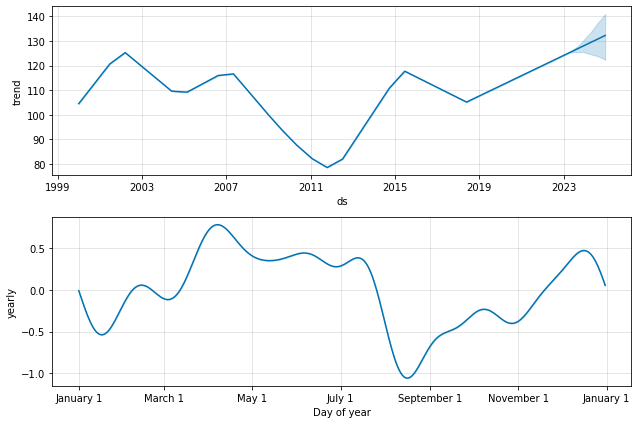

In [13]:
# expose trend and seasonality components
fig_jpy_1 = jpy_model.plot_components(fcst = forecast)